# <p style="font-family: Garamond; font-size: 35px; word-spacing: 10px; padding: 25px; text-align: center; color: #ffffff; border-radius: 25px;  font-weight: bold; background-color: #06066F">REGRESSION WITH A FLOOD PREDICTION DATASET</p>

### The goal of this competition is to predict the probability of a region flooding based on 20 factors: MonsoonIntensity, TopographyDrainage, RiverManagement, Deforestation, Urbanization, ClimateChange, DamsQuality, Siltation, AgriculturalPractices, Encroachments, IneffectiveDisasterPreparedness, DrainageSystems, CoastalVulnerability, Landslides, Watersheds, DeterioratingInfrastructure, PopulationScore, WetlandLoss, InadequatePlanning and PoliticalFactors.  

### The datasets for this competition (both train and test) were generated from a deep learning model trained on the [Flood Prediction Factors dataset](https://www.kaggle.com/datasets/brijlaldhankour/flood-prediction-factors).

### Submissions are evaluated using the R2 score.  


In this notebook we'll perform:   
* Feature engineering,    
* Target encoding,   
* Hyper parameter optimization for a CatBoost model with Bayesian Search and Cross-Validation, and 
* Prediction for test dataset.  


EDA is available here: https://www.kaggle.com/code/marcelamanzosagez/flood-prediction-eda-linear-tree-based-models/notebook

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">LIBRARIES</p>

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import OneToOneFeatureMixin, BaseEstimator, TransformerMixin
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel

from skopt import BayesSearchCV

from catboost import CatBoostRegressor

import os
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from scipy import stats

# Remove the max column restriction for displaying on the screen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from IPython.display import Markdown as md

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
# Helper functions

import random as py_random

def reset_random_seeds(seed=42):
    ''' Set all seeds for random numbers to get reproducibility.'''
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    py_random.seed(seed)


reset_random_seeds()

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">DATA LOADING</p>

In [3]:
%%time

train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')
test  = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

initial_features = train.columns[:-1].to_list()

display(md(f'''
**train shape = {train.shape} (including target)**   
**test shape  = {test.shape}**  

**train dataset:**    
'''))
train.head()


**train shape = (1117957, 21) (including target)**   
**test shape  = (745305, 20)**  

**train dataset:**    


CPU times: user 1.43 s, sys: 329 ms, total: 1.76 s
Wall time: 2.4 s


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">FEATURE ENGINEERING</p>

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">New Features</p>

Credits to:   
- [@ambrosm](https://www.kaggle.com/ambrosm) : https://www.kaggle.com/code/ambrosm/pss4e5-eda-which-makes-sense  
- [@jamesking76](https://www.kaggle.com/jamesking76) : https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499484   
- [@trupologhelper](https://www.kaggle.com/trupologhelper) : https://www.kaggle.com/code/trupologhelper/ps4e5-openfe-blending-explain   
- [@matteobarucco](https://www.kaggle.com/matteobarucco) : https://www.kaggle.com/code/matteobarucco/symmetric-features-0-86908-explanation , https://www.kaggle.com/code/matteobarucco/easy-features-for-0-86933  

In [4]:
def add_features(X):
    
    # Let's add new features based on statistics

    X['fmax']      = X[initial_features].max(axis=1)
    X['fmin']      = X[initial_features].min(axis=1)
    X_mean         = X[initial_features].mean(axis=1)
    X['fsum']      = X[initial_features].sum(axis=1)
    X['fmedian']   = X[initial_features].median(axis=1)
    X['fstd']      = X[initial_features].std(axis=1)    
    X['fmean+std'] = X_mean + X['fstd']
    X['fmean-std'] = X_mean - X['fstd']
    X['fq25th']    = X[initial_features].quantile(q=0.25, axis=1)
    X['fq75th']    = X[initial_features].quantile(q=0.75, axis=1)
    X['fsum_qu']   = X['fq25th'] + X['fmedian'] + X['fq75th']
    X['fsq_sum']   = (X[initial_features]**2).sum(axis=1)
    X['fcb_sum']   = (X[initial_features]**3).sum(axis=1)
    X['fskew']     = X[initial_features].skew(axis=1)
    X['fkurtosis'] = X[initial_features].kurtosis(axis=1)
    
    for i in [10, 20, 30, 40, 60, 70, 80, 90]:
        X[f'fq{i}th'] = X[initial_features].quantile(i/100, axis=1)
    
    X['fgeom_mean'] = np.exp(np.log(X[initial_features]+1).mean(axis=1))
    X['fharm_mean'] = len(initial_features) / (1 / (X[initial_features]+1)).sum(axis=1)
       
    new_cols = [col for col in X.columns if col not in initial_features+['FloodProbability']]

    return X.astype(np.float64), initial_features + new_cols


# add new features for train and test datasets
train, all_features = add_features(train)
test,  _ = add_features(test)

md(f'''
All features = {all_features}   

**New train shape = {train.shape} (including target)**   
**New test shape = {test.shape}** 
''')


All features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors', 'fmax', 'fmin', 'fsum', 'fmedian', 'fstd', 'fmean+std', 'fmean-std', 'fq25th', 'fq75th', 'fsum_qu', 'fsq_sum', 'fcb_sum', 'fskew', 'fkurtosis', 'fq10th', 'fq20th', 'fq30th', 'fq40th', 'fq60th', 'fq70th', 'fq80th', 'fq90th', 'fgeom_mean', 'fharm_mean']   

**New train shape = (1117957, 45) (including target)**   
**New test shape = (745305, 44)** 


In [5]:
display(train.head())

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability,fmax,fmin,fsum,fmedian,fstd,fmean+std,fmean-std,fq25th,fq75th,fsum_qu,fsq_sum,fcb_sum,fskew,fkurtosis,fq10th,fq20th,fq30th,fq40th,fq60th,fq70th,fq80th,fq90th,fgeom_mean,fharm_mean
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.0,8.0,5.0,8.0,6.0,4.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,5.0,4.0,7.0,5.0,7.0,3.0,0.445,8.0,2.0,94.0,4.5,1.750188,6.450188,2.949812,3.00,5.25,12.75,500.0,2950.0,0.577258,-0.521862,3.0,3.0,3.7,4.0,5.0,5.0,6.2,7.1,5.453697,5.219553
1,6.0,7.0,4.0,4.0,8.0,8.0,3.0,5.0,4.0,6.0,9.0,7.0,2.0,0.0,3.0,5.0,3.0,3.0,4.0,3.0,0.450,9.0,0.0,94.0,4.0,2.296450,6.996450,2.403550,3.00,6.25,13.25,542.0,3520.0,0.148339,-0.358403,2.9,3.0,3.0,4.0,5.0,6.0,7.0,8.0,5.154936,4.371964
2,6.0,5.0,6.0,7.0,3.0,7.0,1.0,5.0,4.0,5.0,6.0,7.0,3.0,7.0,5.0,6.0,8.0,2.0,3.0,3.0,0.530,8.0,1.0,99.0,5.0,1.932411,6.882411,3.017589,3.00,6.25,14.25,561.0,3429.0,-0.408083,-0.742415,2.9,3.0,3.7,5.0,6.0,6.0,7.0,7.0,5.587892,5.151267
3,3.0,4.0,6.0,5.0,4.0,8.0,4.0,7.0,6.0,8.0,5.0,2.0,4.0,7.0,4.0,4.0,6.0,5.0,7.0,5.0,0.535,8.0,2.0,104.0,5.0,1.641565,6.841565,3.558435,4.00,6.25,15.25,592.0,3620.0,0.120566,-0.590749,3.9,4.0,4.0,4.6,5.4,6.0,7.0,7.1,5.983190,5.754082
4,5.0,3.0,2.0,6.0,4.0,4.0,3.0,3.0,3.0,3.0,5.0,2.0,2.0,6.0,6.0,4.0,1.0,2.0,3.0,5.0,0.415,6.0,1.0,72.0,3.0,1.500877,5.100877,2.099123,2.75,5.00,10.75,302.0,1410.0,0.253227,-0.922261,2.0,2.0,3.0,3.0,4.0,4.3,5.0,6.0,4.359399,4.113614


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">Feature Correlations With Target</p>

In [6]:
corr = train.corr(method='pearson')
corr[corr.index=='FloodProbability'].T

,FloodProbability
MonsoonIntensity,0.189098
TopographyDrainage,0.187635
RiverManagement,0.187131
Deforestation,0.184001
Urbanization,0.180861
ClimateChange,0.184761
DamsQuality,0.187996
Siltation,0.186789
AgriculturalPractices,0.183366
Encroachments,0.178841


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">Target Encoding</p>   

In EDA we saw that **there was a high correlation** between the sum of all initial features, **fsum** and **FloodProbability**, with R2 = 0.844 (approx).

Now, the main idea is to generate a new feature derived from the average "Flood Probability." To do this:
- We will calculate the average "Flood Probability" for each "fsum" value, and
- We will use a regression technique to predict the average "Food Probability" value, which will be used when an "fsum" value obtained from the validation dataset is not present in the training dataset when performing cross-validation.

The chosen regressor implements a Gaussian process, which is because the evolution of the average "flood probability" over 
"fsum" resembles a time series, as we can see in the following graph.

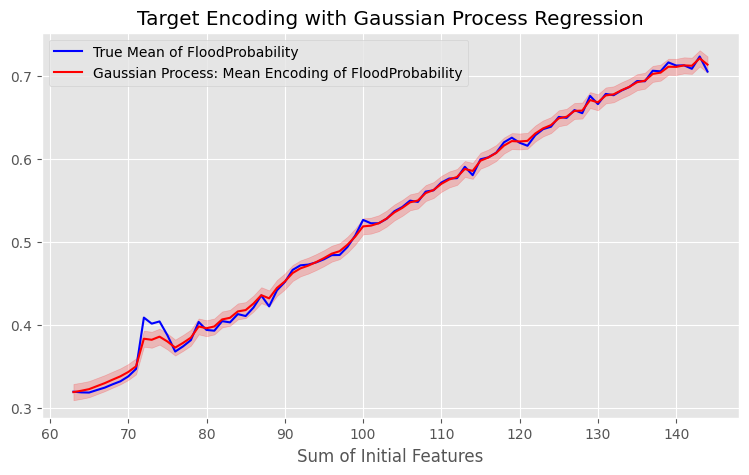

In [7]:
# Calculate the average "Flood Probability" for each value of "fsum"

df = train.groupby('fsum').FloodProbability.mean()
X_train = df.index.values.reshape(-1, 1)
y_train = df.values.reshape(-1, 1)

# Implement a Gaussian process for regression

# Configure kernel 
# Copy from: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
#------------------------------------------------------------------------------------------------
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = ( long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel )
#------------------------------------------------------------------------------------------------

# Define and fit the regressor
y_mean = y_train.mean()
gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)

# Make prediction 
y_predict, y_predict_std = gaussian_process.predict(X_train, return_std=True) 
y_predict += y_mean

fig = plt.figure(figsize=(9,5))
plt.plot(X_train, y_train, color='b', label="True Mean of FloodProbability")
plt.plot(X_train, y_predict, color='r', label="Gaussian Process: Mean Encoding of FloodProbability")
plt.fill_between(
    X_train.ravel(),
    y_predict - y_predict_std,
    y_predict + y_predict_std,
    color='r',
    alpha=0.2,
)
plt.legend()
plt.xlabel('Sum of Initial Features')
plt.ylabel('')
plt.title('Target Encoding with Gaussian Process Regression');

Now, let's define the class "TargetEncodingTransformer" to implement the Gaussian Process Regression.   

In [8]:
class TargetEncodingTransformer(TransformerMixin, BaseEstimator):
    '''Add target encoding to a dataset.'''
    
    def __init__(self, sum_min=55, sum_max=160):
        self.sum_min = sum_min
        self.sum_max = sum_max
        self.sum_enc_dict = {}
        
    def fit(self, X, y=None):
        self.columns = X.columns

        # Calculate mean flood probability for each fsum value
        # 'sum': from 63 to 144 for all train set
        df_sum_enc = y.groupby(X['fsum']).mean() 
        self.sum_enc_dict = df_sum_enc.to_dict()
        #print(self.sum_enc_dict)
        
        #------------------------------------------------------------------------------------------------
        # configure kernel copy from:
        # https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
        
        long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
        seasonal_kernel = (
            2.0**2
            * RBF(length_scale=100.0)
            * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
        )
        irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
        noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
            noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
        )
        kernel = ( long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel )
        #------------------------------------------------------------------------------------------------
        
        # fit gaussian regressor
        y_mean = df_sum_enc.mean()
        gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
        
        with ignore_warnings(category=ConvergenceWarning):
            gaussian_process.fit(
                df_sum_enc.index.values.reshape(-1, 1), 
                df_sum_enc.values.reshape(-1, 1) - y_mean)

        # Predict for full range, X_sum in [sum_min, sum_max]
        X_sum = np.arange(self.sum_min, self.sum_max+1).reshape(-1,1)
        y_predict = gaussian_process.predict(X_sum) + y_mean
        gaussian_mean_dict = dict(zip(X_sum.ravel(), y_predict.ravel()))

        # Update encoding dictionary
        diff_dict = {k:gaussian_mean_dict[k] for k in gaussian_mean_dict if k not in self.sum_enc_dict}
        self.sum_enc_dict.update(diff_dict)
        #print(self.sum_enc_dict)
    
        return self
    
    def transform(self, X):  
        X['ftarget_enc']    = X['fsum'].map(self.sum_enc_dict)
        
        # And add two more features with high correlation with the target
        X['fesp_q25th']    = X['ftarget_enc'] * X['fq25th'] / X['fsum']
        X['fesp_q75th']    = X['ftarget_enc'] * X['fq75th'] / X['fsum']
        return X
    
    def get_feature_names_out(self):
        return self.columns + ['ftarget_enc', 'fesp_q25th', 'fesp_q75th'] 

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 10px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">MODEL TRAINING</p>

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">Hyperparameter Tuning With Bayesian Optimization and Cross-Validation</p>  

In [9]:
def perform_bayes_optimization(features, n_folds, cv_seed, model_seed, 
                               n_iter_bayes_search, bayes_seed, fixed_params, tuning_params, verbose):
    '''
    It performs Bayesian Optimization with Cross-validation.  
    Parameters:
    - features: attributes considered for model optimization.
    - n_folds: number of folds for cross-validation (Bayesian Search parameter).
    - cv_seedv: seed to generate folds for cross-validation (Bayesian Search parameter).    
    - model_seed: seed for random_state (CatBoost parameter).  
    - n_iter_bayes_search: number of parameter settings that are sampled (Bayesian Search parameter).  
    - bayes_seed: seed for generate pseudo random number (Bayesian Search parameter).   
    - fixed_params: parameters that are not tuned (CatBoost parameter).   
    - tuning_params: parameters to be optimized (Bayesian Search parameter).   
    - verbose: Controls the verbosity: the higher, the more messages (Bayesian Search parameter).
    '''
    
    # Add encoding features
    preprocessor = ColumnTransformer([
        ('target_encoding', TargetEncodingTransformer(), features)
    ],
    remainder='drop')
    
    model = Pipeline([
        ("preprocessor", preprocessor),
        ('regressor', CatBoostRegressor(**fixed_params, random_seed=model_seed, verbose=0))
        ])
    
    # Define Bayesian Optimization
    bayes_search = BayesSearchCV(
        estimator= model, 
        search_spaces=tuning_params,
        n_iter=n_iter_bayes_search,
        scoring='r2',  
        #n_jobs , don't use n_jobs to get full CPU use with the regressor
        cv=KFold(n_splits=n_folds, shuffle=True, random_state=cv_seed),
        verbose=verbose,
        random_state=bayes_seed,
        refit=False
    )

    # Run Bayesian Optimization
    bayes_search.fit(train[features], train.FloodProbability)
    
    best_params = bayes_search.best_params_
    best_params = {k.split('__')[1]: best_params[k] for k in best_params}

    print("\nBest parameters: ", best_params)
    print(f"Best cross-validation R2: {bayes_search.best_score_:.4f}")
    
    return bayes_search, best_params

#===========================================================================================================

def retrain_best_model(features, n_folds, cv_seed, model_seed, fixed_params, best_tuning_params):
    '''
    It retrains a model with the best hyperparameters found with Bayesian optimization.  
    Parameters:
    - features: attributes considered for model optimization.
    - n_folds: number of folds for cross-validation (Bayesian Search parameter).
    - cv_seedv: seed to generate folds for cross-validation (Bayesian Search parameter).    
    - model_seed: seed for random_state (CatBoost parameter).  
    - fixed_params: parameters that are not tuned (CatBoost parameter).   
    - best_tuning_params: best hyperparameters found with Bayesian optimization.   
    '''
    
    valid_pred      = np.zeros(len(train), dtype=float) # record predictions for validation dataset oof
    test_pred       = np.zeros(len(test), dtype=float)  # record predictions for test dataset
    scores_r2_train = [] # train scores
    scores_r2_valid = [] # oof scores r2
    model_dict      = {} # record models

    # Cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=cv_seed)

    for fold, (train_index, valid_index) in enumerate(kf.split(train)):
        
        X_train = train.loc[train_index, features]
        y_train = train.FloodProbability[train_index]
        X_valid = train.loc[valid_index, features]
        y_valid = train.FloodProbability[valid_index]
        
        # Add encoding features
        preprocessor = ColumnTransformer([
            ('target_encoding', TargetEncodingTransformer(), features)
        ],
        remainder='drop')
        
        model = Pipeline([
            ("preprocessor", preprocessor),
            ('regressor', CatBoostRegressor(**fixed_params, **best_tuning_params, random_state=model_seed, verbose=0))
        ])

        # Train model
        model.fit(X_train, y_train)      
        model_dict[fold] = model

        # Predictions
        valid_pred[valid_index] = model.predict(X_valid)
        test_pred = test_pred + model.predict(test)

        # Scores
        score_r2_train = r2_score(y_train, model.predict(X_train))
        scores_r2_train.append(score_r2_train)

        score_r2_valid = r2_score(y_valid, model.predict(X_valid))
        scores_r2_valid.append(score_r2_valid)

        print(f'fold {fold+1}/{n_folds}  -  r2 train= {score_r2_train:.4f}  -  r2 valid = {score_r2_valid:.4f}')

        del X_train, y_train, X_valid, y_valid
        gc.collect()

    # Average test predictions
    test_pred = test_pred / n_folds

    # Calculate mean scores
    mean_r2_train = np.mean(scores_r2_train)
    mean_r2_valid = np.mean(scores_r2_valid)
    
    print(f'cv r2 train = {mean_r2_train:.4f}  -  cv r2 valid = {mean_r2_valid:.4f}')

    return test_pred, valid_pred, model_dict

#===========================================================================================================

def optimize_retrain_predict(features, n_folds, cv_seed, model_seed, 
                             n_iter_bayes_search, bayes_seed, fixed_params, tuning_params, verbose=1):
    '''
    Parameters:
    - features: attributes considered for model optimization.
    - n_folds: number of folds for cross-validation (Bayesian Search parameter).
    - cv_seedv: seed to generate folds for cross-validation (Bayesian Search parameter).    
    - model_seed: seed for random_state (CatBoost parameter).  
    - n_iter_bayes_search: number of parameter settings that are sampled (Bayesian Search parameter).  
    - bayes_seed: seed for generate pseudo random number (Bayesian Search parameter).   
    - fixed_params: parameters that are not tuned (CatBoost parameter).   
    - tuning_params: parameters to be optimized (Bayesian Search parameter).   
    - verbose: Controls the verbosity: the higher, the more messages (Bayesian Search parameter).
    '''
        
    # Hyperparameter tuning with Bayesian Search
    print('Performing Hyperparameter tuning for Catboost with Bayesian Search')
    bayes_search, best_tuning_params = perform_bayes_optimization(
        features = features,
        n_folds=n_folds, 
        cv_seed=cv_seed, 
        model_seed=model_seed, 
        n_iter_bayes_search=n_iter_bayes_search, 
        bayes_seed=bayes_seed,
        fixed_params=fixed_params,
        tuning_params=tuning_params,
        verbose=verbose)
    
    # Retrain model and predict
    print('\nRetraining and prediction with the best model found')
    test_pred, valid_pred, model_dict = retrain_best_model(
        features=features,
        n_folds=n_folds, 
        cv_seed=cv_seed, 
        model_seed=model_seed, 
        fixed_params=fixed_params, 
        best_tuning_params=best_tuning_params)
   
    return bayes_search, model_dict, test_pred, valid_pred

In [10]:
# Global variables ########################################
N_FOLDS             = 5  # Number of folds for cross-validation
CV_SEED             = 42 # Seed for Kfold cross-validation
MODEL_SEED          = 42 # Seed for CatB "random_state" parameter
N_ITER_BAYES_SEARCH = 50 # Number of BayesSearchCV iterations
BAYES_SEED          = 0  # Seed for Bayes "random_state" parameter 

# Basic params ############################################
golden_feature = str(all_features.index('fsum')) + ':border_count=1024'
FIXED_PARAMS = {
    'boosting_type'                  : 'Plain',
    'grow_policy'                    : 'Lossguide',
    #'per_float_feature_quantization' : [golden_feature],
    'task_type'                      : 'GPU'
}

# List of hyperparameters for tuning ######################
TUNING_PARAMS = {
    'regressor__n_estimators'     : (1000, 3000), # default 1000 
    'regressor__max_depth'        : (6, 10),    #default 6 (16 if the growing policy is set to Lossguide)  
    'regressor__num_leaves'       : (31, 511),  #default 31 
    #'regressor__grow_policy'      : ['SymmetricTree', 'Depthwise', 'Lossguide'], # default SymmetricTree just CPU
    #'regressor__subsample'        : (0.8, 1.0), # default 1  just CPU
    'regressor__learning_rate'    : (0.01, 0.03), # default 0.03 
    'regressor__min_child_samples': (1, 120),   # default = 1 
    'regressor__reg_lambda'       : (0.00001, 100.0, 'log-uniform'), # default 3.0  
    #'regressor__random_strength'  : (1.0, 5.0), # default 1 just CPU 
    #'regressor__colsample_bylevel': (0.8, 1.0) # default 1.0 just CPU
}

In [11]:
%%time

# Hyperparameter tuning and predictions

# valid_pred records predictions for validation dataset oof
# test_pred records predictions for test dataset
# model_dict records the best model per fold

bayes_search, model_dict, test_pred, valid_pred = optimize_retrain_predict(
    features=all_features,
    n_folds=N_FOLDS, 
    cv_seed=CV_SEED, 
    model_seed=MODEL_SEED, 
    n_iter_bayes_search=N_ITER_BAYES_SEARCH, 
    bayes_seed=BAYES_SEED, 
    fixed_params=FIXED_PARAMS, 
    tuning_params=TUNING_PARAMS, 
    verbose=0
)

Performing Hyperparameter tuning for Catboost with Bayesian Search

Best parameters:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 93, 'n_estimators': 1000, 'num_leaves': 372, 'reg_lambda': 1e-05}
Best cross-validation R2: 0.8693

Retraining and prediction with the best model found
fold 1/5  -  r2 train= 0.8740  -  r2 valid = 0.8691
fold 2/5  -  r2 train= 0.8739  -  r2 valid = 0.8697
fold 3/5  -  r2 train= 0.8740  -  r2 valid = 0.8691
fold 4/5  -  r2 train= 0.8740  -  r2 valid = 0.8693
fold 5/5  -  r2 train= 0.8740  -  r2 valid = 0.8693
cv r2 train = 0.8739  -  cv r2 valid = 0.8693
CPU times: user 6h 37min 29s, sys: 1h 31min 8s, total: 8h 8min 37s
Wall time: 3h 58min 45s


# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">Optimization History Plot</p>

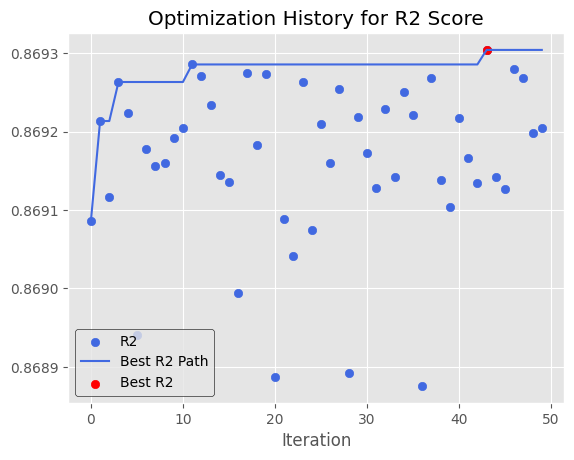

In [12]:
def plot_optimization_history(bayes_search):
    
    y = bayes_search.optimizer_results_[0]['func_vals']
    y = [-i for i in y]
    best_path = [np.max(y[:(i+1)]) for i in range(len(y))]
    
    plt.scatter(x=range(len(y)), y=y, color='RoyalBlue', label='R2')
    plt.plot(best_path, color='Royalblue', label='Best R2 Path')
    plt.scatter(np.argmax(y), np.max(y), color='r', label='Best R2')
    plt.title('Optimization History for R2 Score')
    plt.xlabel('Iteration')
    #plt.ylabel('R2 Score')
    plt.legend(loc='best', edgecolor='black')
    plt.show()
    
    
plot_optimization_history(bayes_search)

# <p style="font-family: Garamond; font-size: 25px; word-spacing: 5px; padding: 0px; text-align: left; color: #06066F; font-weight: bold; border-bottom: 3px solid #06066F;">Feature Importance</p>

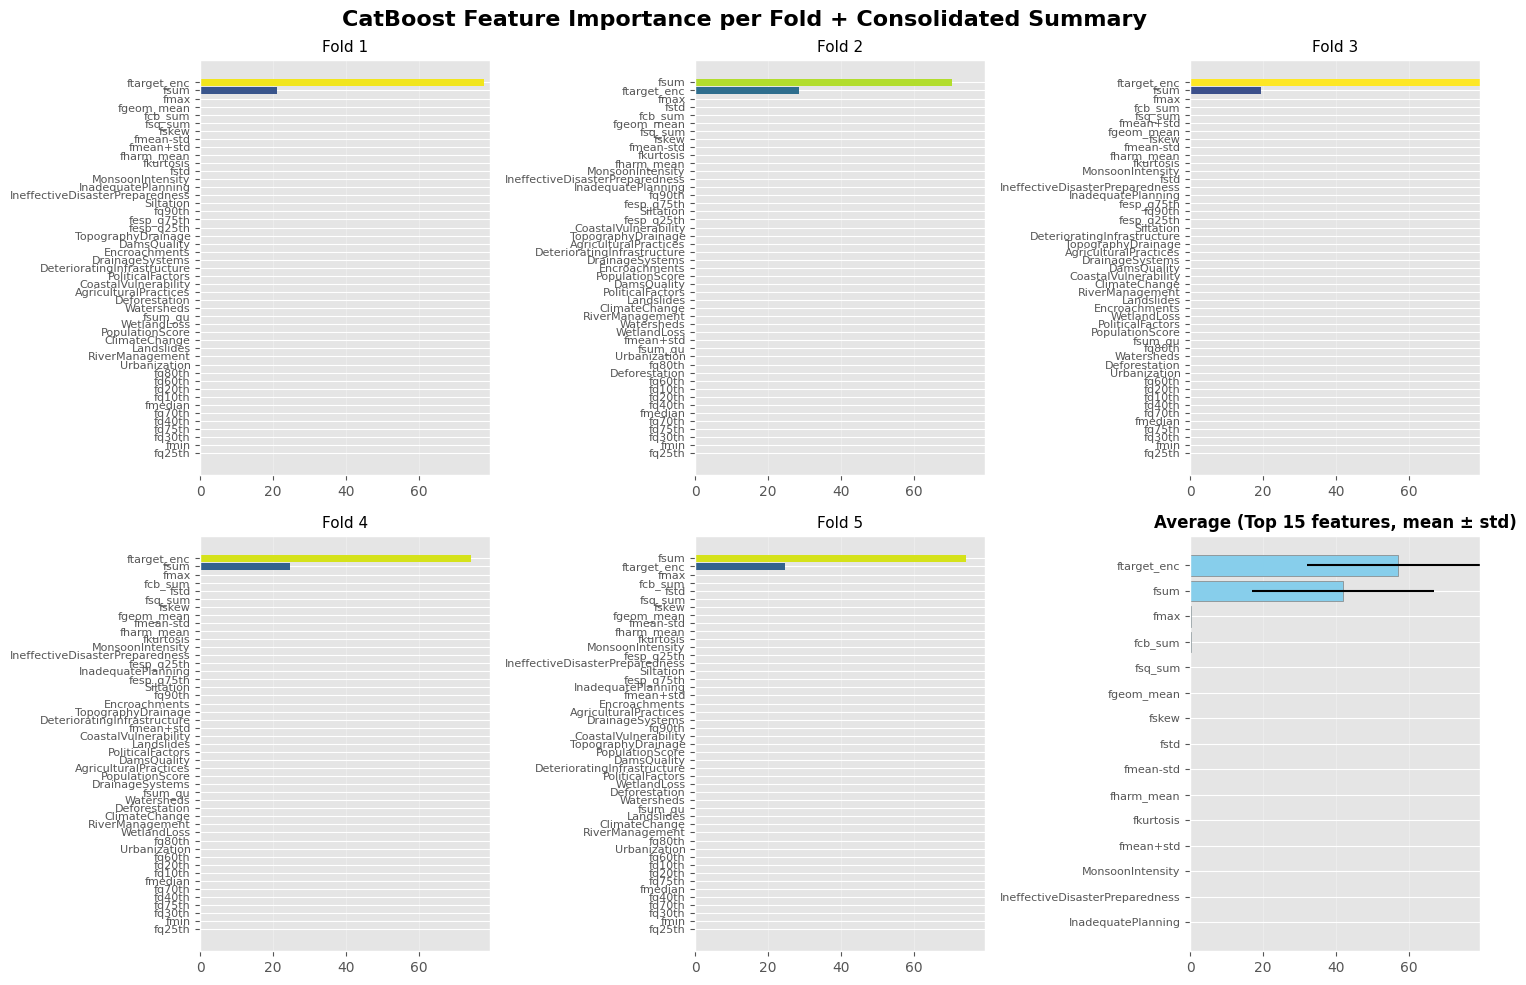

In [13]:
def plot_cv_feature_importances(model_dict, all_features, top_n=15):
    '''
    Displays CatBoost feature importances for multiple CV folds
    and includes a consolidated (mean ± std) plot as the sixth subplot
    in a 2x3 grid (second row, third column).

    Parameters:
    - model_dict : dict
         Dictionary containing the CatBoost models for each CV fold.
         Each entry must include a key 'regressor' with the trained model.
    - all_features : list
         List of base feature names.
    - top_n : int, default=15
         Number of top features to display in the consolidated (summary) plot.
    '''
    
    n_models = len(model_dict)
    extended_features = all_features + ['ftarget_enc', 'fesp_q25th', 'fesp_q75th']

    # Collect all feature importances from each model 
    all_importances = np.array([
        model_dict[m]['regressor'].get_feature_importance(type='PredictionValuesChange')
        for m in range(n_models)
    ])

    # Compute mean and std importance across folds
    mean_imp = all_importances.mean(axis=0)
    std_imp  = all_importances.std(axis=0)
    max_imp  = all_importances.max()

    # Create a 2x3 grid 
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()

    # Plot feature importance for each fold 
    for m in range(n_models):
        feature_importances = all_importances[m]
        sorted_idx = feature_importances.argsort()

        axs[m].barh(
            range(len(feature_importances)),
            feature_importances[sorted_idx],
            color=plt.cm.viridis(feature_importances[sorted_idx] / max_imp)
        )
        axs[m].set_yticks(range(len(feature_importances)))
        axs[m].set_yticklabels([extended_features[i] for i in sorted_idx], fontsize=8)
        axs[m].set_xlim(0, max_imp)
        axs[m].set_title(f'Fold {m+1}', fontsize=11)
        axs[m].grid(alpha=0.3, axis='x')

    # Consolidated (average) plot 
    ax_sum = axs[5]
    sorted_idx = np.argsort(mean_imp)[-top_n:]  # Select top_n features
    mean_top = mean_imp[sorted_idx]
    std_top = std_imp[sorted_idx]
    features_top = [extended_features[i] for i in sorted_idx]

    ax_sum.barh(
        range(top_n),
        mean_top,
        xerr=std_top,
        color='skyblue', edgecolor='gray'
    )
    ax_sum.set_yticks(range(top_n))
    ax_sum.set_yticklabels(features_top, fontsize=8)
    ax_sum.set_xlim(0, max_imp)
    ax_sum.set_title(f'Average (Top {top_n} features, mean ± std)', fontsize=12, weight='bold')
    ax_sum.grid(alpha=0.3, axis='x')

    fig.suptitle('CatBoost Feature Importance per Fold + Consolidated Summary', fontsize=16, weight='bold')
    fig.tight_layout()
    
    plt.show()


plot_cv_feature_importances(model_dict, all_features)

# <p style="font-family: Garamond; font-size: 25px; padding: 15px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #06066F;">SUBMISSION</p>

In [14]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

submission['FloodProbability'] = test_pred
submission.to_csv('submission_bayes_catb.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.577654
1,1117958,0.455382
2,1117959,0.447684
3,1117960,0.465785
4,1117961,0.466549
